# Running an adaptive speciaton model in a static landscape

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

%matplotlib inline

# Functions to compute and visualize speciation model¶

In [2]:
def run_model(trait_comp=False, num_gen=500, init_abundance=50, dt=1,
             sigma_env_trait=0.3, mut_prob=0.005, sigma_mut=0.05, sigma_mov=0.12,
             random_seed=1234, taxon_threshold=0.05, taxon_def='traits'):
    """
    Main function to compute one of the two speciation models
    
    Parameters
    ----------
    
    trait_comp: bool, 
                If False it will compute the speciation model without 
                competition (Irwin 2012 Am. Nat.) or if True the model 
                with competition (Doebeli & Dieckmann 2003 Nature).
    num_gen: int
             maximum number of generations to compute.
    init_abundance: int
                    initial number of individuals.
    dt: float
        time step of the simulation
    sigma_env_trait: float
                     enviromental fitness variability.
    mut_prob: float
              mutation probability.
    sigma_mut: float
               trait variability of mutated offspring.
    sigma_mov: float
               dispersal variability of offspring. The spatial extend to disperse is normalize 
               to 0 and 1 thus the value should be between 0 to 1.
    random_seed: int
                 seed of the random number generator
    taxon_threshold: float
                     threshold value to separate taxa in the spectral clustering algorithm.
    taxon_def: str
               If 'traits' taxon are defined as sharing common ancestry and similar trait values
               or if 'traits_location' spatial location is in addition to the previous variables
               included into the clustering algorithm.
    """
    #build a static landscape with single gradient along the x coordinate
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(random_seed)
    environment = X + r.rand(*Y.shape)
    # Initialize traits and environmental fields for speciation models
    # First we initialize one trait associated with elevation where the 
    # initial min/max provides the range of trait values that the individual 
    # will have and where the slope determines the linear relationship between
    # environmental field and the optimal trait value for each individual on that field.
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    # define one of the two types speciation models
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, init_abundance,
                                    car_cap_max=500, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    sigma_comp_trait=0.9, sigma_comp_dist=0.19, taxon_threshold=taxon_threshold, 
                                    taxon_def=taxon_def)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, init_abundance, 
                                    nb_radius=50, car_cap=50, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    taxon_threshold=taxon_threshold, taxon_def=taxon_def)
    print(model)
    # initialize the model
    model.initialize()
    dfs = []
    # main loop to execute and store model resutls
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, environment, X):
    """
    Plot solution of the model result.
    
    Parameters
    ----------
    dtf: pd.DataFrame
         with results of the speciation model
    environment: array-like
                 environmental field
    X: array-like
       x coordinate
    """
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    axs1_2 = axs1[0,0].twinx()
    axs1_2.plot(dtf.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
    
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(environment)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')
    axs1_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')

In [4]:
def plot_spatial_dist(df, environment):
    """
    Plot spatial distribution of individuals over the environemnt in selected time steps.
    
    Parameters
    ----------
    dtf: pd.DataFrame
         with results of the speciation model
    environment: array-like
                 environmental field
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
    for ax, print_step in zip(axes.ravel(), np.linspace(0,df.step.unique().size-1,10).astype(int)):
        pop = df.groupby('step').get_group(print_step)
        ax.pcolormesh(environment)
        ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
        ax.set_title(f't = {print_step}, size = {len(pop)}')
    fig.tight_layout()

## Speciation model without trait-mediated competition

In [5]:
%time df1, environment, x = run_model(trait_comp=False)
df1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    nb_radius: 50
    car_cap: 50
    sigma_env_trait: 0.3
    sigma_mov: 0.12
    sigma_mut: 0.05
    mut_prob: 0.005



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 4min 42s, sys: 54.9 s, total: 5min 37s
Wall time: 57.9 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,134.141559,1.0,0.0,3,0.321134,0.5000
1,0,0.0,0.0,95.048934,183.307913,1.0,0.0,9,0.932762,0.5000
2,0,0.0,0.0,230.811558,112.227697,1.0,0.0,4,0.405857,0.5000
3,0,0.0,0.0,65.423106,76.375192,1.0,0.0,3,0.751546,0.5000
4,0,0.0,0.0,79.774265,236.839901,1.0,0.0,11,0.849979,0.5000
...,...,...,...,...,...,...,...,...,...,...
222273,499,499.0,0.0,140.116810,236.407257,1895.0,1893.0,1,0.469689,0.1896
222274,499,499.0,0.0,67.002909,234.780037,1895.0,1893.0,1,0.956651,0.1896
222275,499,499.0,0.0,1.178201,161.271510,1895.0,1893.0,1,0.870539,0.1896
222276,499,499.0,0.0,21.594293,73.879813,1895.0,1893.0,1,0.965816,0.1896


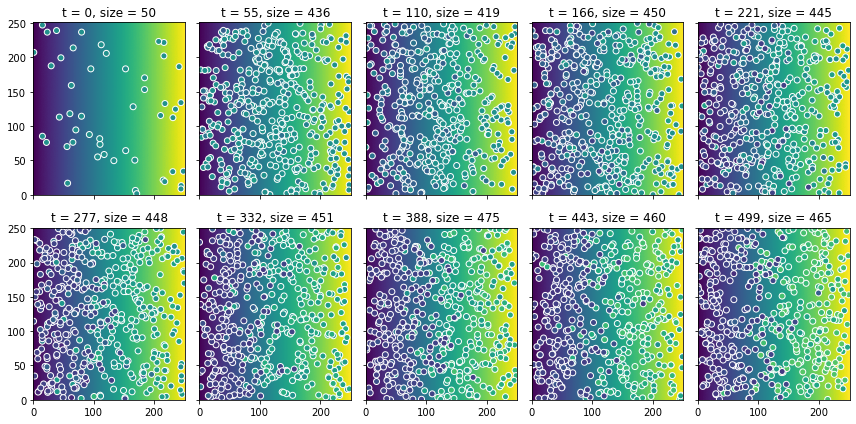

In [6]:
plot_spatial_dist(df1, environment)

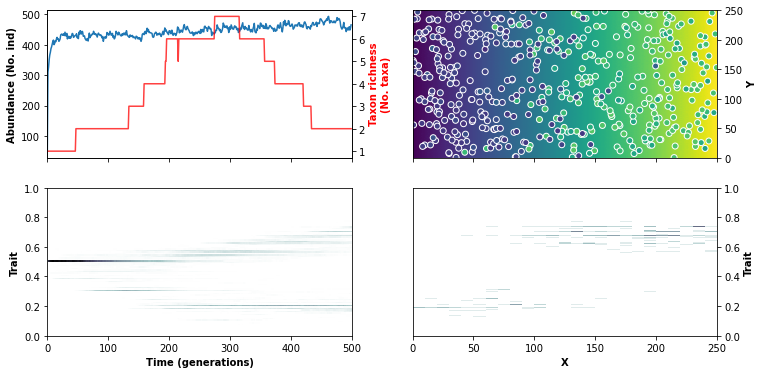

In [7]:
plot_sol(df1, environment, x)

## Speciation model with trait-mediated competition

In [8]:
%time df2, environment, x = run_model(trait_comp=True)
df2

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    birth_rate: 1
    car_cap_max: 500
    sigma_env_trait: 0.3
    mut_prob: 0.005
    sigma_mut: 0.05
    sigma_mov: 0.12
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.19



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 10min 6s, sys: 2min 9s, total: 12min 15s
Wall time: 1min 58s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,death_i,trait_0
0,0,0.0,0.0,244.174942,134.141559,1.0,0.0,5,0.321134,0.197122,0.500000
1,0,0.0,0.0,95.048934,183.307913,1.0,0.0,48,0.932762,0.081075,0.500000
2,0,0.0,0.0,230.811558,112.227697,1.0,0.0,6,0.405857,0.172303,0.500000
3,0,0.0,0.0,65.423106,76.375192,1.0,0.0,8,0.751546,0.129093,0.500000
4,0,0.0,0.0,79.774265,236.839901,1.0,0.0,0,0.849979,0.072511,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
272274,499,499.0,0.0,224.703842,54.798469,1977.0,1974.0,1,0.989306,0.831779,0.924248
272275,499,499.0,0.0,222.084039,100.311079,1977.0,1974.0,1,0.981921,0.834833,0.924248
272276,499,499.0,0.0,223.693379,213.325393,1977.0,1974.0,0,0.987247,0.661337,0.924248
272277,499,499.0,0.0,223.443716,110.268167,1977.0,1974.0,0,0.983798,0.815804,0.924248


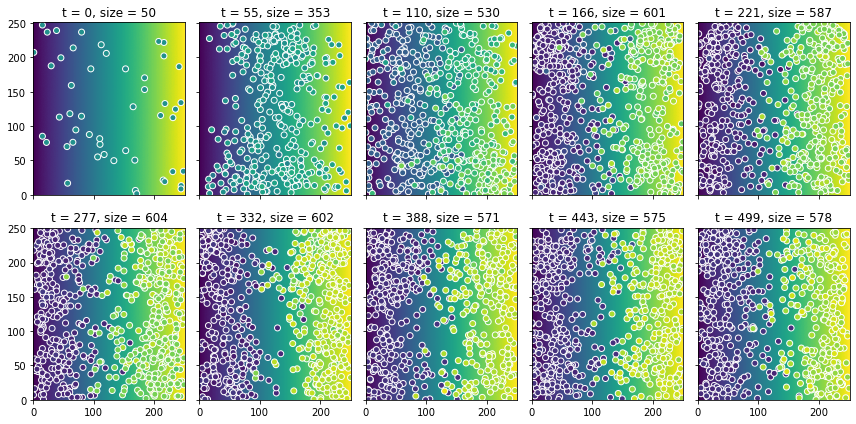

In [9]:
plot_spatial_dist(df2, environment)

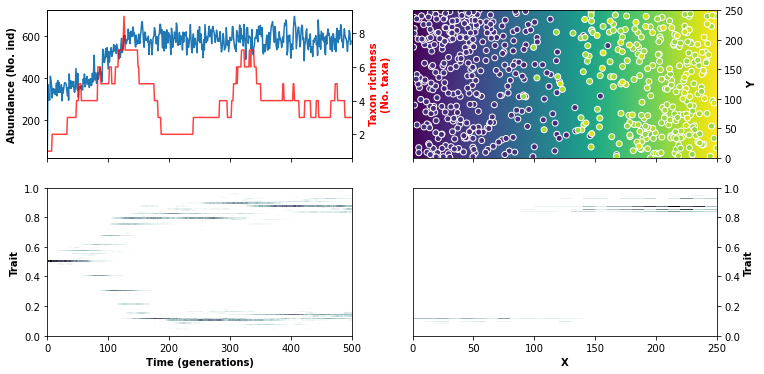

In [10]:
plot_sol(df2, environment, x)